# Rotated MNIST: Model Training Notebook (Standalone)

This notebook trains and compares:
- Logistic Regression
- Standard CNN
- Rotation-Equivariant CNN (E2CNN) on a class-balanced subset of the Rotated MNIST dataset.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from e2cnn import gspaces
from e2cnn import nn as enn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

import random, os
    

In [23]:
# Set seed and device
seed = 42
random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

In [24]:

# Data preparation with balanced validation split
def get_dataloaders(batch_size=64, subset_fraction=1.0, seed=42):
    transform = transforms.Compose([
        transforms.RandomRotation(degrees=(-180, 180)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    full_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    
    if subset_fraction < 1.0:
        class_indices = {i: [] for i in range(10)}
        for idx, (_, label) in enumerate(full_dataset):
            class_indices[label].append(idx)
        samples_per_class = int((len(full_dataset) * subset_fraction) / 10)
        balanced_indices = [random.sample(class_indices[i], samples_per_class) for i in range(10)]
        balanced_indices = [item for sublist in balanced_indices for item in sublist]
        random.shuffle(balanced_indices)
        subset = Subset(full_dataset, balanced_indices)
    else:
        subset = full_dataset

    train_size = int(0.8 * len(subset))
    val_size = len(subset) - train_size
    train_set, val_set = random_split(subset, [train_size, val_size])

    test_set = datasets.MNIST('data', train=False, download=True, transform=transform)
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_set, batch_size=batch_size)
    )
    

In [25]:

# Simple Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)
    

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [27]:
class RotEquivariantCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=8)

        in_type = enn.FieldType(r2_act, [r2_act.trivial_repr])
        self.input_type = in_type

        self.block1 = enn.SequentialModule(
            enn.R2Conv(
                in_type,
                enn.FieldType(r2_act, 8 * [r2_act.regular_repr]),
                kernel_size=5,
                padding=2,
                bias=False,
            ),
            enn.ReLU(enn.FieldType(r2_act, 8 * [r2_act.regular_repr]), inplace=True),
            enn.PointwiseMaxPool(
                enn.FieldType(r2_act, 8 * [r2_act.regular_repr]), kernel_size=2
            ),
        )

        self.block2 = enn.SequentialModule(
            enn.R2Conv(
                self.block1.out_type,
                enn.FieldType(r2_act, 16 * [r2_act.regular_repr]),
                kernel_size=5,
                padding=2,
                bias=False,
            ),
            enn.ReLU(enn.FieldType(r2_act, 16 * [r2_act.regular_repr]), inplace=True),
            enn.PointwiseMaxPool(
                enn.FieldType(r2_act, 16 * [r2_act.regular_repr]), kernel_size=2
            ),
        )

        c = self.block2.out_type.size
        self.fc1 = nn.Linear(c * 7 * 7, num_classes)

    def forward(self, x):
        x = enn.GeometricTensor(x, self.input_type)
        x = self.block1(x)
        x = self.block2(x)
        x = x.tensor
        x = x.view(x.size(0), -1)
        return self.fc1(x)


In [28]:
def train_model(model, train_loader, val_loader, device, epochs=10, model_name='model', save_best=True):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_f1 = 0
    best_model_state = None

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": [],
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0  # running loss added
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()  # accumulate loss

        train_loss = running_loss / len(train_loader)  # compute average
        history["train_loss"].append(train_loss)

        # Validation
        model.eval()
        val_running_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item() * inputs.size(0)

                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        acc = accuracy_score(all_targets, all_preds)
        precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(acc)
        history["val_precision"].append(precision)
        history["val_recall"].append(recall)
        history["val_f1"].append(f1)

        if save_best and f1 > best_f1:
            best_f1 = f1
            best_model_state = model.state_dict()

        print(f"📘 Epoch {epoch+1}/{epochs}")
        print(f"   🔹 Train Loss: {train_loss:.4f}")
        print(f"   🔸 Val Loss: {val_loss:.4f} | Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    print("✅ Training complete")

    if save_best and best_model_state is not None:
        model.load_state_dict(best_model_state)
        save_path = os.path.join(f"{model_name}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model saved as {save_path}")

    # Plotting Train vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), history["train_loss"], label="Train Loss", color='blue', linestyle='--')
    plt.plot(range(epochs), history["val_loss"], label="Validation Loss", color='red', linestyle='-')
    plt.title(f'{model_name} - Train vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history


📘 Epoch 1/10
   🔹 Train Loss: 1.9761
   🔸 Val Loss: 1.6971 | Acc: 0.3950 | Precision: 0.3892 | Recall: 0.4003 | F1: 0.3688
📘 Epoch 2/10
   🔹 Train Loss: 1.6057
   🔸 Val Loss: 1.5316 | Acc: 0.4417 | Precision: 0.4205 | Recall: 0.4466 | F1: 0.4100
📘 Epoch 3/10
   🔹 Train Loss: 1.5110
   🔸 Val Loss: 1.5068 | Acc: 0.4517 | Precision: 0.4419 | Recall: 0.4537 | F1: 0.4346
📘 Epoch 4/10
   🔹 Train Loss: 1.4745
   🔸 Val Loss: 1.4703 | Acc: 0.4650 | Precision: 0.4526 | Recall: 0.4711 | F1: 0.4502
📘 Epoch 5/10
   🔹 Train Loss: 1.4576
   🔸 Val Loss: 1.4576 | Acc: 0.4833 | Precision: 0.4676 | Recall: 0.4922 | F1: 0.4606
📘 Epoch 6/10
   🔹 Train Loss: 1.4291
   🔸 Val Loss: 1.4435 | Acc: 0.4633 | Precision: 0.4517 | Recall: 0.4758 | F1: 0.4413
📘 Epoch 7/10
   🔹 Train Loss: 1.4082
   🔸 Val Loss: 1.4261 | Acc: 0.4900 | Precision: 0.4698 | Recall: 0.4930 | F1: 0.4672
📘 Epoch 8/10
   🔹 Train Loss: 1.3988
   🔸 Val Loss: 1.4292 | Acc: 0.5000 | Precision: 0.4844 | Recall: 0.5028 | F1: 0.4792
📘 Epoch 9/10
   

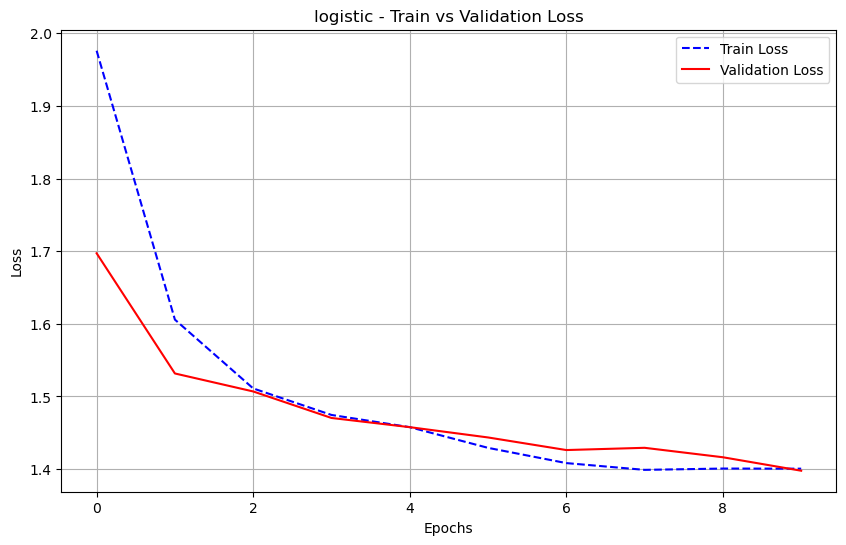

In [29]:
# Run training
train_loader, val_loader, test_loader = get_dataloaders(subset_fraction=0.05)
model = LogisticRegression()
trained_model = train_model(model, train_loader, val_loader, device, model_name="logistic")

📘 Epoch 1/10
   🔹 Train Loss: 1.7399
   🔸 Val Loss: 1.3919 | Acc: 0.5300 | Precision: 0.5403 | Recall: 0.5307 | F1: 0.5218
📘 Epoch 2/10
   🔹 Train Loss: 1.1725
   🔸 Val Loss: 1.0160 | Acc: 0.6683 | Precision: 0.6843 | Recall: 0.6668 | F1: 0.6533
📘 Epoch 3/10
   🔹 Train Loss: 0.8677
   🔸 Val Loss: 0.8569 | Acc: 0.7200 | Precision: 0.7284 | Recall: 0.7165 | F1: 0.7163
📘 Epoch 4/10
   🔹 Train Loss: 0.7379
   🔸 Val Loss: 0.7163 | Acc: 0.7583 | Precision: 0.7577 | Recall: 0.7567 | F1: 0.7555
📘 Epoch 5/10
   🔹 Train Loss: 0.6461
   🔸 Val Loss: 0.7016 | Acc: 0.7600 | Precision: 0.7634 | Recall: 0.7568 | F1: 0.7570
📘 Epoch 6/10
   🔹 Train Loss: 0.5801
   🔸 Val Loss: 0.6868 | Acc: 0.7500 | Precision: 0.7671 | Recall: 0.7481 | F1: 0.7481
📘 Epoch 7/10
   🔹 Train Loss: 0.5265
   🔸 Val Loss: 0.6048 | Acc: 0.8067 | Precision: 0.8056 | Recall: 0.8056 | F1: 0.8045
📘 Epoch 8/10
   🔹 Train Loss: 0.4776
   🔸 Val Loss: 0.5468 | Acc: 0.8083 | Precision: 0.8074 | Recall: 0.8081 | F1: 0.8062
📘 Epoch 9/10
   

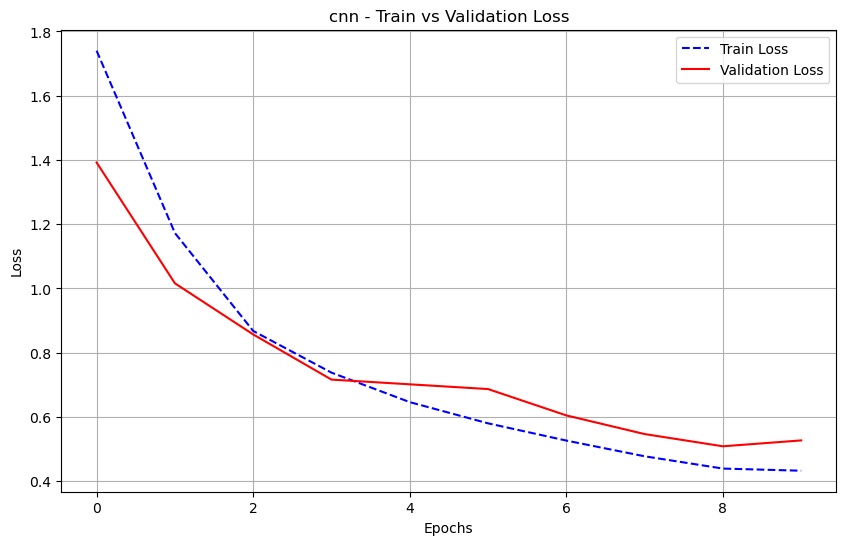

In [30]:
# Run training
train_loader, val_loader, test_loader = get_dataloaders(subset_fraction=0.05)
model = SimpleCNN()
trained_model = train_model(model, train_loader, val_loader, device, model_name="cnn")

📘 Epoch 1/10
   🔹 Train Loss: 2.0450
   🔸 Val Loss: 1.0897 | Acc: 0.6767 | Precision: 0.6726 | Recall: 0.6673 | F1: 0.6580
📘 Epoch 2/10
   🔹 Train Loss: 0.8939
   🔸 Val Loss: 0.6829 | Acc: 0.7900 | Precision: 0.8014 | Recall: 0.7758 | F1: 0.7716
📘 Epoch 3/10
   🔹 Train Loss: 0.6669
   🔸 Val Loss: 0.5428 | Acc: 0.8400 | Precision: 0.8403 | Recall: 0.8329 | F1: 0.8325
📘 Epoch 4/10
   🔹 Train Loss: 0.5502
   🔸 Val Loss: 0.4197 | Acc: 0.8733 | Precision: 0.8752 | Recall: 0.8672 | F1: 0.8684
📘 Epoch 5/10
   🔹 Train Loss: 0.4673
   🔸 Val Loss: 0.4246 | Acc: 0.8700 | Precision: 0.8697 | Recall: 0.8669 | F1: 0.8653
📘 Epoch 6/10
   🔹 Train Loss: 0.4113
   🔸 Val Loss: 0.4373 | Acc: 0.8483 | Precision: 0.8672 | Recall: 0.8379 | F1: 0.8359
📘 Epoch 7/10
   🔹 Train Loss: 0.3977
   🔸 Val Loss: 0.3408 | Acc: 0.8983 | Precision: 0.8986 | Recall: 0.8963 | F1: 0.8965
📘 Epoch 8/10
   🔹 Train Loss: 0.3358
   🔸 Val Loss: 0.3261 | Acc: 0.9033 | Precision: 0.8998 | Recall: 0.9006 | F1: 0.8999
📘 Epoch 9/10
   

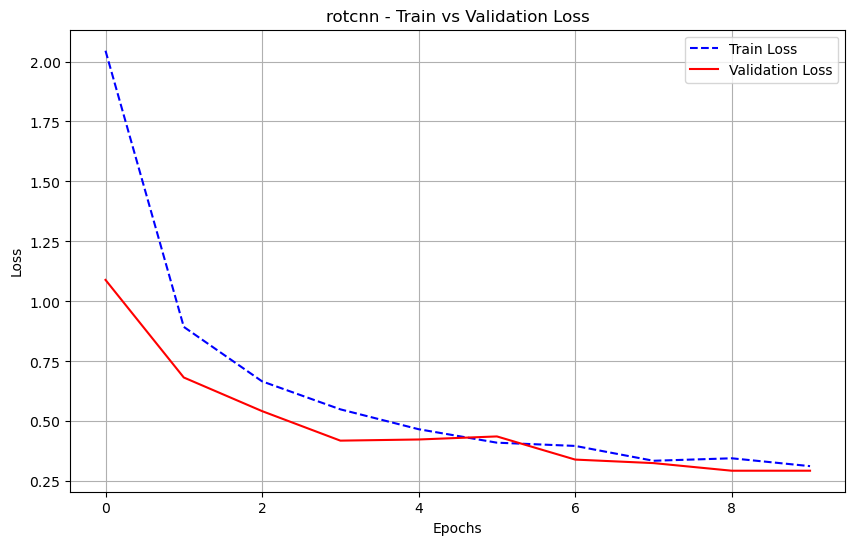

In [34]:
# Run training
train_loader, val_loader, test_loader = get_dataloaders(subset_fraction=0.05)
model = RotEquivariantCNN()
trained_model = train_model(model, train_loader, val_loader, device, model_name="rotcnn")